In [28]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.graphics.tsaplots as sg
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
pd.set_option('display.float_format', lambda x: '%.10f' % x)
from sklearn.metrics import r2_score
import datetime as dt 

%matplotlib inline

In [2]:
path = '/nfshome/skp454/DOE/'

### JFK Incoming flights
1. read and concat files
2. aggregate into 3 hrs bucket

In [3]:
# read and concat files
df_jfkMain = pd.DataFrame()
for file in os.listdir(path+'data/'):
    if 'JFK' in file and 'Dest' in file:
        df_jfkTemp =  pd.read_csv(path+'data/'+file)
        df_jfkMain = df_jfkMain.append(df_jfkTemp)

# view data        
print("length Jfk: ", len(df_jfkMain))
df_jfkMain.head()

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


length Jfk:  63959


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div4TailNum,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate
0,2018,1,3,1,4,2018/3/1,AA,AA_CODESHARE,19805,AA,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,N
1,2018,1,3,2,5,2018/3/2,AA,AA_CODESHARE,19805,AA,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,N
2,2018,1,3,3,6,2018/3/3,AA,AA_CODESHARE,19805,AA,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,N
3,2018,1,3,4,7,2018/3/4,AA,AA_CODESHARE,19805,AA,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,N
4,2018,1,3,5,1,2018/3/5,AA,AA_CODESHARE,19805,AA,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,N


In [4]:
# remove all columns except flight date and arrival time
df_jfkMain = df_jfkMain[['Year','Month','DayofMonth','ArrTime','FlightDate']]

# drop na
df_jfkMain.dropna(inplace=True)

#convert ArrTime to string
df_jfkMain['ArrTime'] = df_jfkMain['ArrTime'].astype(str)

# reset index
df_jfkMain.reset_index(drop = True, inplace = True)

# view data        
print("length Jfk: ", len(df_jfkMain))
df_jfkMain.head()

length Jfk:  61674


,Year,Month,DayofMonth,ArrTime,FlightDate
0,2018,3,1,1520.0,2018/3/1
1,2018,3,3,1541.0,2018/3/3
2,2018,3,4,1509.0,2018/3/4
3,2018,3,5,1717.0,2018/3/5
4,2018,3,6,1527.0,2018/3/6


In [5]:
#extract hour from ArrTime
df_jfkMain['Hour'] = df_jfkMain.apply(lambda x: x['ArrTime'][:-4], axis=1)

#drop unusual
df_jfkMain = df_jfkMain[df_jfkMain['Hour'] != '']

#hour to int
df_jfkMain['Hour'] = df_jfkMain['Hour'].astype(int)
print(df_jfkMain['Hour'].unique())

# view data        
print("length Jfk: ", len(df_jfkMain))
df_jfkMain.head()

[15 17 16 19 18 14 20  7  8 13 21 22 23  5  1  6  2  9 10  3 24 11 12  4]
length Jfk:  59857


,Year,Month,DayofMonth,ArrTime,FlightDate,Hour
0,2018,3,1,1520.0,2018/3/1,15
1,2018,3,3,1541.0,2018/3/3,15
2,2018,3,4,1509.0,2018/3/4,15
3,2018,3,5,1717.0,2018/3/5,17
4,2018,3,6,1527.0,2018/3/6,15


In [6]:
# create time bucket 3 hours and concat with date
def timebucket(row):
    year = str(row['Year'])
    month = str(row['Month'])
    day = str(row['DayofMonth'])
    hour = str(int(np.ceil(row['Hour']/3)))
    if len(day)<2:
        day = '0'+ day
    return year+month+day+hour

In [7]:
# time bucket of each row
df_jfkMain['TimeBucket'] = df_jfkMain.apply(lambda x: timebucket(x), axis = 1)

# len of time bucket
len(df_jfkMain['TimeBucket'].unique())

# sort by time bucket
df_jfkMain = df_jfkMain.sort_values(by = ['TimeBucket'], ascending=True)

# groupby time bucket
df_jfkTS = df_jfkMain.groupby(['TimeBucket'])['DayofMonth'].count()

# reset index
#df_jfkTS.reset_index(drop = True, inplace = True)

Text(0.5, 1.0, 'Time Series for No. of Incoming Flights ')

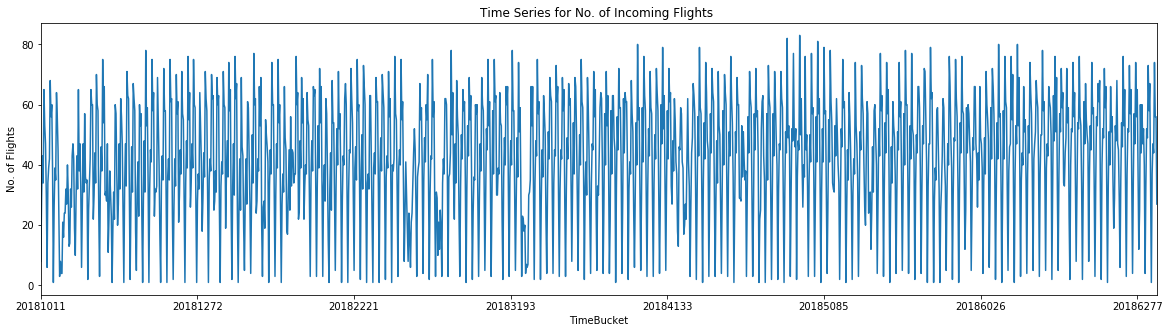

In [8]:
plt.subplots(figsize = (20,5))
df_jfkTS.plot()
plt.ylabel('No. of Flights')
plt.title("Time Series for No. of Incoming Flights ")

### Yellow Cab Outgoing Traffic

In [9]:
# import yellow cab data
df_jfkYellowMain = pd.read_csv(path+'data/'+'yellow_JFK_out_15.csv')

# view data
df_jfkYellowMain.head()

,Unnamed: 0,start_time_index,counts,index_of_day,weekday,day
0,0,0,53,0,0,0
1,1,1,42,1,0,0
2,2,2,43,2,0,0
3,3,3,36,3,0,0
4,4,4,38,4,0,0


#### Please Note: 
1. The day variable corresponds to day of the year
2. The start_time_index corresponds to 96 fifteen minutes bucket of the day (24hour/15minutes = 96 Buckets)
3. We need to convert these two to time bucket matching that of jfk_flight data.

In [10]:
# convert dy to date
df_jfkYellowMain['Date'] = df_jfkYellowMain.apply(lambda x: pd.to_datetime('1/1/2018') + pd.DateOffset(x['day']), axis =1)

# view data
df_jfkYellowMain.head()

,Unnamed: 0,start_time_index,counts,index_of_day,weekday,day,Date
0,0,0,53,0,0,0,2018-01-01
1,1,1,42,1,0,0,2018-01-01
2,2,2,43,2,0,0,2018-01-01
3,3,3,36,3,0,0,2018-01-01
4,4,4,38,4,0,0,2018-01-01


In [13]:
# create time bucket 3 hours and concat with date
def timebucket_cab(row):
    year = str(row['Date'].year)
    month = str(row['Date'].month)
    day = str(row['Date'].day)
    hour = str(int(np.ceil((row['index_of_day']+1)/12)))
    if len(day)<2:
        day = '0'+ day
    return year+month+day+hour

In [14]:
# time bucket of each row
df_jfkYellowMain['TimeBucket'] = df_jfkYellowMain.apply(lambda row: timebucket_cab(row), axis = 1)

# sort by time bucket
df_jfkYellowMain = df_jfkYellowMain.sort_values(by = ['TimeBucket'], ascending=True)

# groupby time bucket
df_jfkYellowTS = df_jfkYellowMain.groupby(['TimeBucket'])['counts'].sum()

Text(0.5, 1.0, 'Time Series for No. of Outgoing Cabs')

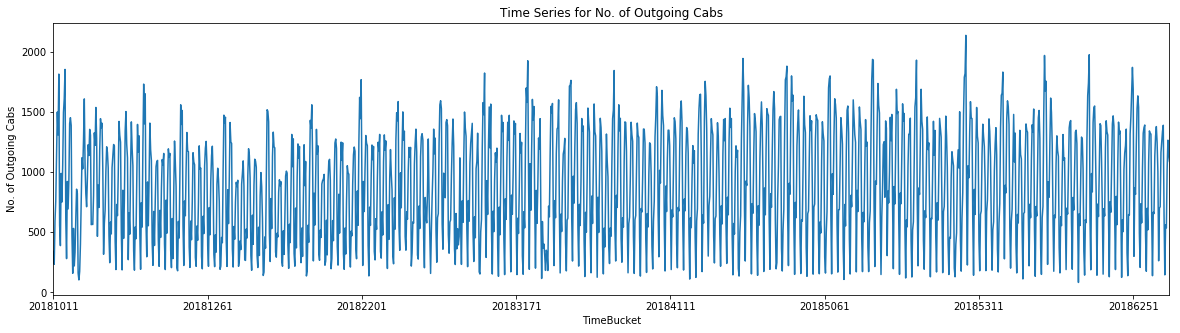

In [17]:
plt.subplots(figsize = (20,5))
df_jfkYellowTS.plot()
plt.ylabel('No. of Outgoing Cabs')
plt.title("Time Series for No. of Outgoing Cabs")

### Join Flight and Cab Data
1. Join both data
2. Check linear relation between both

In [89]:
# Merge both data
df_jfk = pd.concat([df_jfkTS,df_jfkYellowTS], axis=1)

# fill na
df_jfk.fillna(0, inplace = True)

#change column names
df_jfk.columns = ['nFlights', 'nCabs']

#View data
df_jfk.head()

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,nFlights,nCabs
20181011,8.0000000000,340
20181012,29.0000000000,233
20181013,43.0000000000,591
20181014,34.0000000000,758
20181015,65.0000000000,1136


In [90]:
def daytime(row):
    a = str(row['Timestamp'])
    x = dt.datetime(int(a[0:4]), int(a[4:5]), int(a[5:7]))
    return x.weekday(), a[7:8]

In [91]:
df_jfk['Timestamp'] = df_jfk.index
df_jfk['Day'], df_jfk['Time'] = zip(*df_jfk.apply(lambda x: daytime(x), axis =1))
df_jfk = pd.concat([df_jfk, pd.get_dummies(df_jfk['Day'], prefix='Day')], axis=1)
df_jfk = pd.concat([df_jfk, pd.get_dummies(df_jfk['Time'], prefix='Time')], axis=1)
df_jfk.head()

,nFlights,nCabs,Timestamp,Day,Time,Day_0,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Time_1,Time_2,Time_3,Time_4,Time_5,Time_6,Time_7,Time_8
20181011,8.0000000000,340,20181011,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
20181012,29.0000000000,233,20181012,0,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
20181013,43.0000000000,591,20181013,0,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
20181014,34.0000000000,758,20181014,0,4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
20181015,65.0000000000,1136,20181015,0,5,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Correlation b/w nFlights & nCabs: 0.5223458831056713


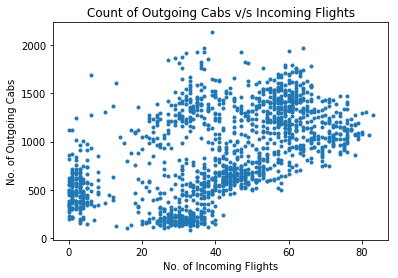

In [92]:
# Plot scatter plot of flights and cab
plt.plot(df_jfk['nFlights'], df_jfk['nCabs'],'.')
plt.xlabel('No. of Incoming Flights')
plt.ylabel('No. of Outgoing Cabs')
plt.title( 'Count of Outgoing Cabs v/s Incoming Flights')
print("Correlation b/w nFlights & nCabs:", np.corrcoef(df_jfk['nFlights'], df_jfk['nCabs'])[0][1])

### Model 1:  Without Intercept

In [31]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights-1', data = df_jfk).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     6381.
Date:                Sat, 01 Jun 2019   Prob (F-statistic):               0.00
Time:                        21:45:03   Log-Likelihood:                -10828.
No. Observations:                1448   AIC:                         2.166e+04
Df Residuals:                    1447   BIC:                         2.166e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nFlights      19.4956      0.244     79.884      0.0

Text(0, 0.5, 'No.of Cabs')

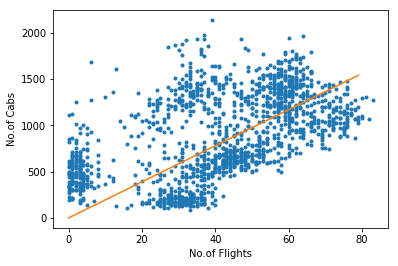

In [32]:
# Scatter plot with best fit line
plt.plot(df_jfk['nFlights'], df_jfk['nCabs'],'.')
plt.plot(np.arange(0,80,1), np.arange(0,80,1) * lm.params['nFlights'], '-')
plt.xlabel('No.of Flights')
plt.ylabel('No.of Cabs')


In [33]:
df_jfk['predCabs'] = lm.params['nFlights'] * df_jfk['nFlights']
df_jfk['resCabs'] = df_jfk['nCabs'] - df_jfk['predCabs']
mse = mean_squared_error(df_jfk['nCabs'],df_jfk['predCabs'])
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 427.923


Text(0.5, 0, 'Residual')

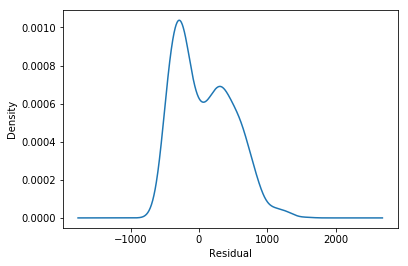

In [34]:
df_jfk['resCabs'].plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

### Model 2:  With Intercept

In [93]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights', data = df_jfk).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     542.6
Date:                Thu, 06 Jun 2019   Prob (F-statistic):          3.62e-102
Time:                        22:00:54   Log-Likelihood:                -10692.
No. Observations:                1448   AIC:                         2.139e+04
Df Residuals:                    1446   BIC:                         2.140e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    400.8692     23.146     17.319      0.0

Text(0, 0.5, 'No.of Cabs')

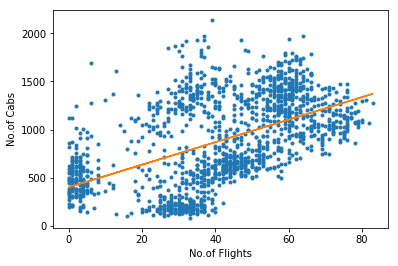

In [98]:
# Scatter plot with best fit line
plt.plot(df_jfk['nFlights'], df_jfk['nCabs'],'.')
plt.plot(df_jfk['nFlights'], lm.predict(), '-')
plt.xlabel('No.of Flights')
plt.ylabel('No.of Cabs')

In [100]:
df_jfk['predCabs'] = lm.predict()
df_jfk['resCabs'] = df_jfk['nCabs'] - df_jfk['predCabs']
mse = mean_squared_error(df_jfk['nCabs'],df_jfk['predCabs'])
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 389.435


Text(0.5, 0, 'Residual')

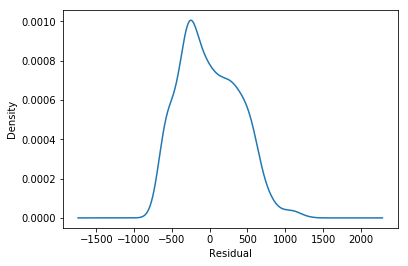

In [101]:
df_jfk['resCabs'].plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

### Model3: With Time of Day & Day of Week Dummies

In [102]:
'nFlights+Day_0+Day_1+Day_2+Day_3+Day_4+Day_5+Day_6+Time_1+Time_2+Time_3+Time_4+Time_5+Time_6+Time_7+Time_8'

Index(['nFlights', 'nCabs', 'Timestamp', 'Day', 'Time', 'Day_0', 'Day_1',
       'Day_2', 'Day_3', 'Day_4', 'Day_5', 'Day_6', 'Time_1', 'Time_2',
       'Time_3', 'Time_4', 'Time_5', 'Time_6', 'Time_7', 'Time_8', 'predCabs',
       'resCabs'],
      dtype='object')

In [103]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights+Day_0+Day_1+Day_2+Day_3+Day_4+Day_5+Day_6+Time_1+\
Time_2+Time_3+Time_4+Time_5+Time_6+Time_7+Time_8', data = df_jfk).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     616.1
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:07:11   Log-Likelihood:                -9511.4
No. Observations:                1448   AIC:                         1.905e+04
Df Residuals:                    1433   BIC:                         1.913e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    428.8447     18.192     23.574      0.0

In [104]:
df_jfk['predCabs'] = lm.predict()
df_jfk['resCabs'] = df_jfk['nCabs'] - df_jfk['predCabs']
mse = mean_squared_error(df_jfk['nCabs'],df_jfk['predCabs'])
rmse = np.sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 172.378


Text(0.5, 0, 'Residual')

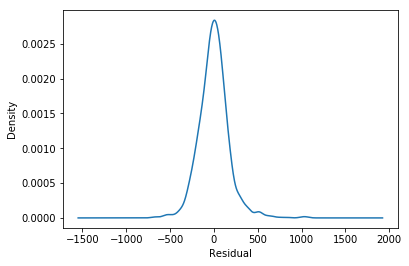

In [105]:
df_jfk['resCabs'].plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

## ARIMA MODELLING

### Cab Time Series

In [79]:
# Series = df_jfk['nCabs']
# Series = np.array(Series.iloc[8:]) - np.array(Series.iloc[:-8])

In [80]:
# plt.figure(figsize=(20, 5))
# plt.plot(Series)

In [106]:
# check for stationarity
# result = adfuller(Series)
result = adfuller(df_jfk['nCabs'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.124699
p-value: 0.000013
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


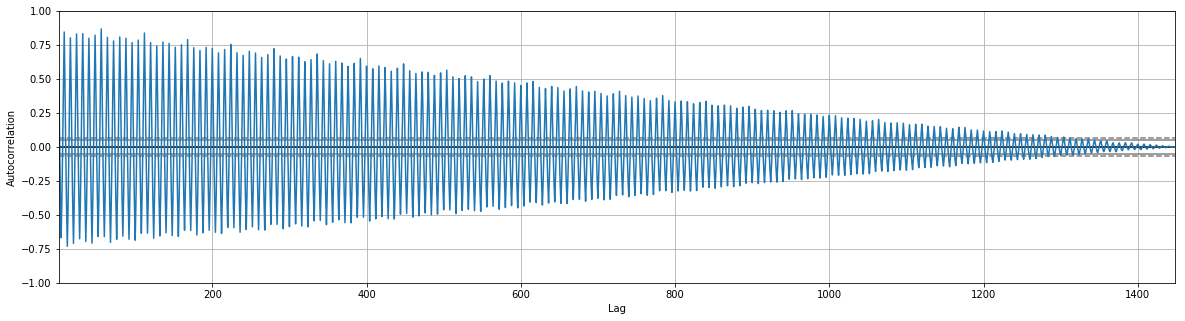

In [107]:
# plot autocorrelation in the data
plt.figure(figsize=(20, 5))
# ax = autocorrelation_plot(Series)
ax = autocorrelation_plot(df_jfk['nCabs'])


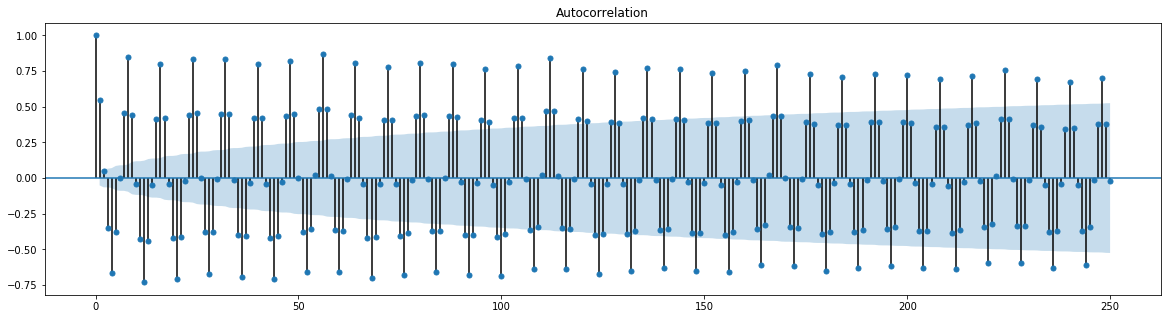

In [108]:
fig, ax = plt.subplots(1, figsize=(20, 5))
# sg.plot_acf(Series, ax=ax, lags=250)
sg.plot_acf(df_jfk['nCabs'], ax=ax, lags=250)
plt.show()

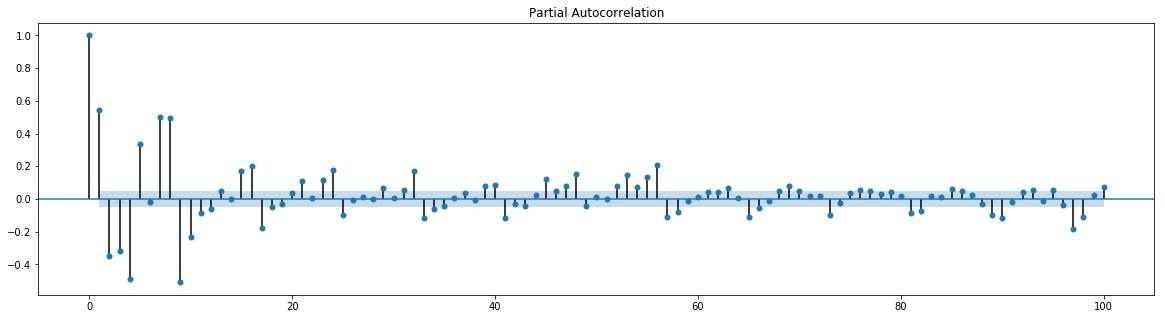

In [109]:
fig, ax = plt.subplots(1, figsize=(20, 5))
# sg.plot_pacf(Series, lags=100, ax= ax)
sg.plot_pacf(df_jfk['nCabs'], lags=100, ax= ax)
plt.show()

In [110]:
# fit model
model = ARIMA(df_jfk['nCabs'], order=(8,1,4))
model_fit_cab = model.fit(disp=0)
print(model_fit_cab.summary())

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.nCabs   No. Observations:                 1447
Model:                 ARIMA(8, 1, 4)   Log Likelihood               -9548.294
Method:                       css-mle   S.D. of innovations            176.688
Date:                Thu, 06 Jun 2019   AIC                          19124.587
Time:                        22:09:20   BIC                          19198.469
Sample:                             1   HQIC                         19152.160
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1170      2.171     -0.054      0.957      -4.373       4.139
ar.L1.D.nCabs    -0.4022        nan        nan        nan         nan         nan
ar.L2.D.nCabs    -0.5055        nan     

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [139]:
results_cab = pd.concat([df_jfk['nCabs'],model_fit_cab.resid], axis = 1)
results_cab.dropna(inplace =True)
r2_score(results_cab['nCabs'], results_cab['nCabs'] - results_cab[0])  


/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


0.8468781853087057

(array([  1.,   2.,   4.,   2.,   6.,   9.,  13.,  33.,  73., 122., 169.,
        245., 218., 186., 140.,  95.,  58.,  28.,  16.,  14.,   3.,   2.,
          3.,   0.,   3.,   0.,   1.,   0.,   0.,   1.]),
 array([-757.89474802, -696.38286273, -634.87097744, -573.35909216,
        -511.84720687, -450.33532158, -388.82343629, -327.311551  ,
        -265.79966572, -204.28778043, -142.77589514,  -81.26400985,
         -19.75212456,   41.75976072,  103.27164601,  164.7835313 ,
         226.29541659,  287.80730188,  349.31918716,  410.83107245,
         472.34295774,  533.85484303,  595.36672832,  656.8786136 ,
         718.39049889,  779.90238418,  841.41426947,  902.92615476,
         964.43804004, 1025.94992533, 1087.46181062]),
 <a list of 30 Patch objects>)

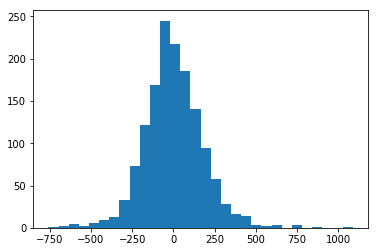

In [112]:
plt.hist(model_fit_cab.resid, bins = 30)

Text(0.5, 0, 'Residual')

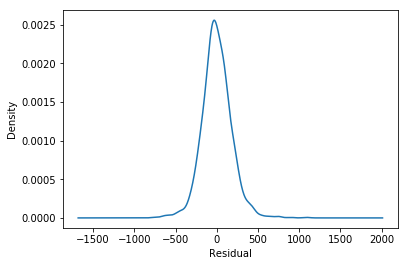

In [113]:
pd.Series(model_fit_cab.resid).plot(kind='kde', ax=plt.gca())
plt.xlabel('Residual')

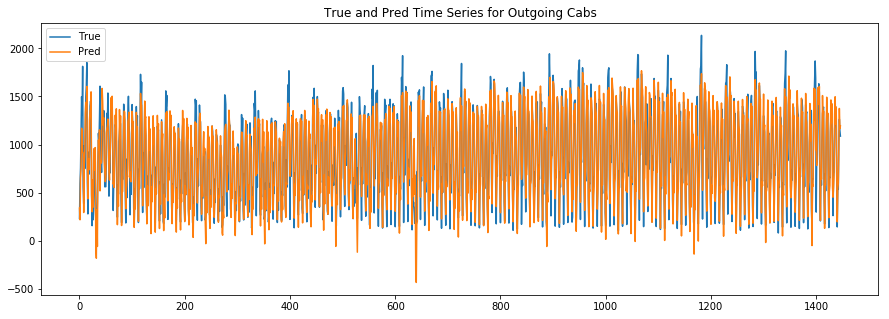

In [114]:
plt.subplots(figsize=(15,5))
plt.plot(np.arange(0,len(results_cab['nCabs']),1),results_cab['nCabs'], '-', label ='True')
plt.plot(np.arange(0,len(results_cab['nCabs']),1),results_cab['nCabs'] - results_cab[0], '-', label ='Pred')
plt.title("True and Pred Time Series for Outgoing Cabs")
plt.legend()

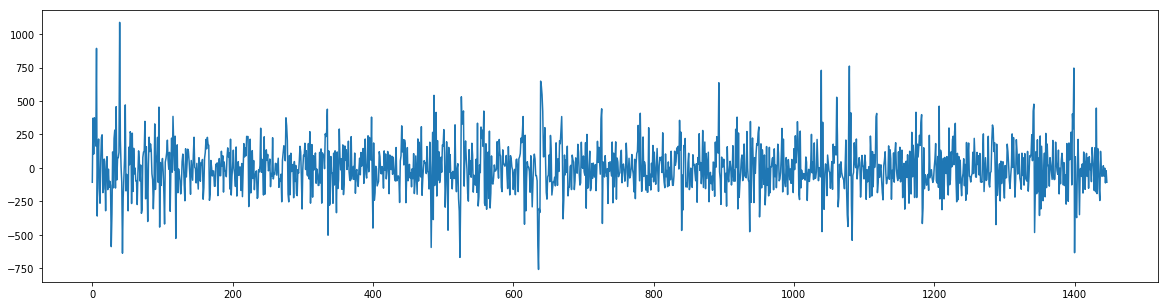

In [115]:
plt.subplots(figsize=(20,5))
plt.plot(np.arange(0,len(model_fit_cab.resid),1),model_fit_cab.resid)

### JFK Time Series

In [116]:
# check for stationarity
# result = adfuller(Series)
result = adfuller(df_jfk['nFlights'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.989151
p-value: 0.000023
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


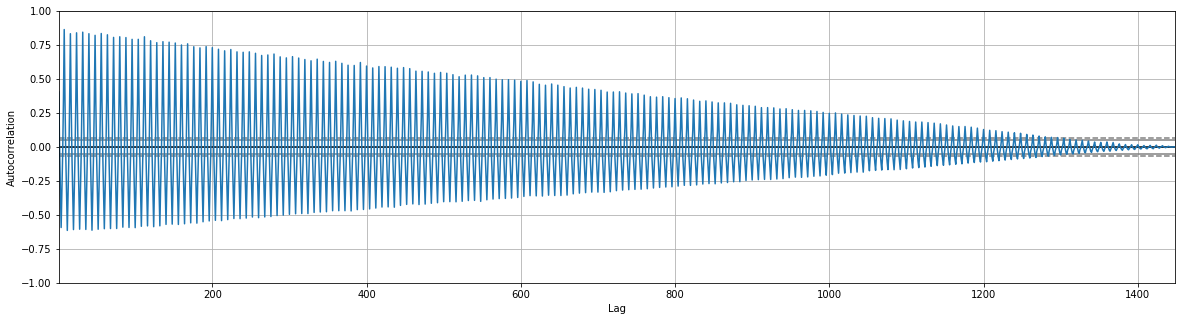

In [117]:
# plot autocorrelation in the data
plt.figure(figsize=(20, 5))
# ax = autocorrelation_plot(Series)
ax = autocorrelation_plot(df_jfk['nFlights'])


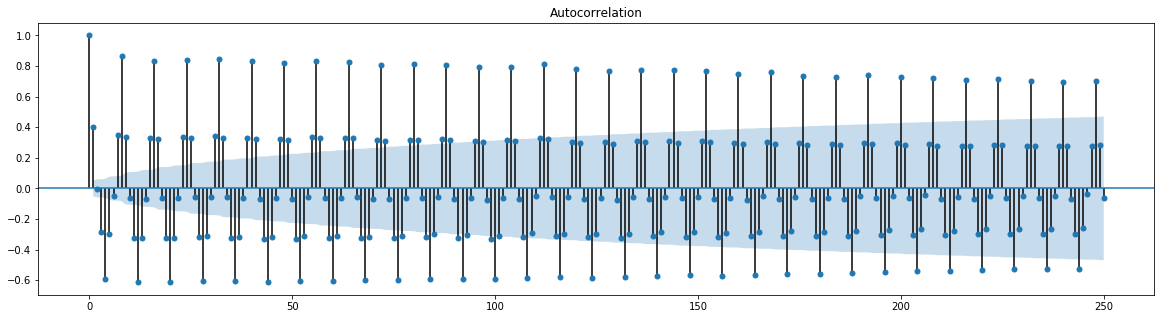

In [118]:
fig, ax = plt.subplots(1, figsize=(20, 5))
# sg.plot_acf(Series, ax=ax, lags=250)
sg.plot_acf(df_jfk['nFlights'], ax=ax, lags=250)
plt.show()

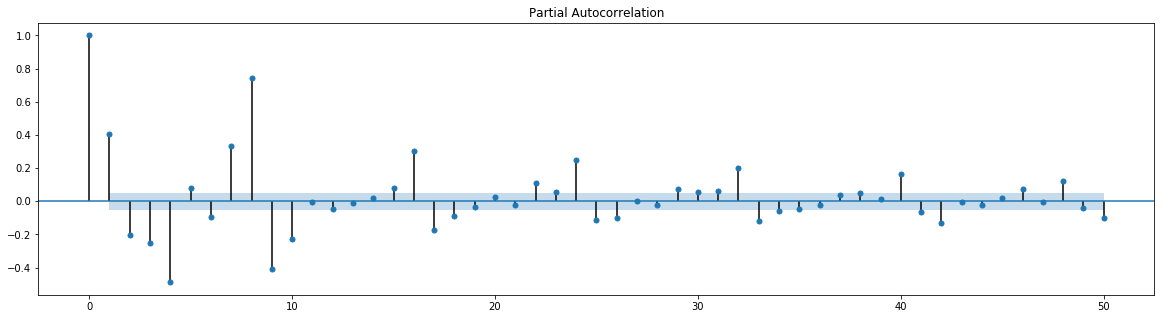

In [119]:
fig, ax = plt.subplots(1, figsize=(20, 5))
# sg.plot_pacf(Series, lags=100, ax= ax)
sg.plot_pacf(df_jfk['nFlights'], lags=50, ax= ax)
plt.show()

In [120]:
# fit model
model = ARIMA(df_jfk['nFlights'], order=(8,1,4))
model_fit_flight = model.fit(disp=0)
print(model_fit_flight.summary())

/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.nFlights   No. Observations:                 1447
Model:                 ARIMA(8, 1, 4)   Log Likelihood               -5208.151
Method:                       css-mle   S.D. of innovations              8.814
Date:                Thu, 06 Jun 2019   AIC                          10444.301
Time:                        22:09:40   BIC                          10518.183
Sample:                             1   HQIC                         10471.874
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0017      0.071      0.025      0.980      -0.138       0.142
ar.L1.D.nFlights    -0.4149      0.069     -6.027      0.000      -0.550      -0.280
ar.L2.D.nFlights    -0.4816 

In [121]:
results_flight = pd.concat([df_jfk['nFlights'],model_fit_flight.resid], axis = 1)
results_flight.dropna(inplace =True)
r2_score(results_flight['nFlights'], results_flight['nFlights'] - results_flight[0])  


/nfshome/skp454/.conda/envs/skp/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


0.8103305242305153

(array([  1.,   0.,   3.,   1.,   3.,   1.,   4.,   4.,   8.,  11.,  17.,
         32.,  67., 113., 212., 220., 203., 190., 133., 103.,  47.,  31.,
         18.,   6.,   6.,   6.,   2.,   2.,   2.,   1.]),
 array([-47.09945291, -44.19378861, -41.28812431, -38.38246001,
        -35.47679571, -32.57113141, -29.66546711, -26.75980281,
        -23.85413851, -20.94847421, -18.04280991, -15.13714561,
        -12.23148131,  -9.32581701,  -6.42015271,  -3.51448841,
         -0.60882411,   2.29684019,   5.20250449,   8.10816879,
         11.0138331 ,  13.9194974 ,  16.8251617 ,  19.730826  ,
         22.6364903 ,  25.5421546 ,  28.4478189 ,  31.3534832 ,
         34.2591475 ,  37.1648118 ,  40.0704761 ]),
 <a list of 30 Patch objects>)

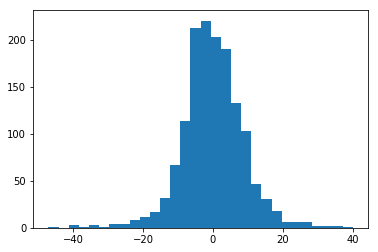

In [122]:
plt.hist(model_fit_flight.resid, bins = 30)

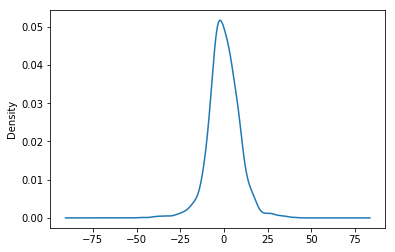

In [123]:
pd.Series(model_fit_flight.resid).plot(kind='kde', ax=plt.gca())

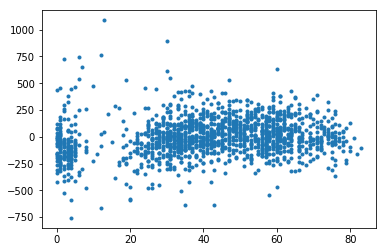

In [124]:
plt.plot(results_flight['nFlights'], results_cab[0], '.')

In [125]:
np.corrcoef(results_flight['nFlights'], results_cab[0])

array([[1.        , 0.17892832],
       [0.17892832, 1.        ]])

In [126]:
np.corrcoef(results_flight['nFlights'], results_cab['nCabs'] - results_cab[0])

array([[1.        , 0.47257645],
       [0.47257645, 1.        ]])

## Linear Model

In [141]:
df_linear = pd.DataFrame(results_cab)
df_linear['arPred'] = df_linear['nCabs'] - df_linear[0]
df_linear = pd.concat([df_linear['arPred'], df_jfk.iloc[1:,:]], axis = 1)


### Model 1: Without intercept

In [144]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights+arPred-1', data = df_linear).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 2.337e+04
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:16:20   Log-Likelihood:                -9505.2
No. Observations:                1447   AIC:                         1.901e+04
Df Residuals:                    1445   BIC:                         1.902e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nFlights       2.2775      0.222     10.246      0.0

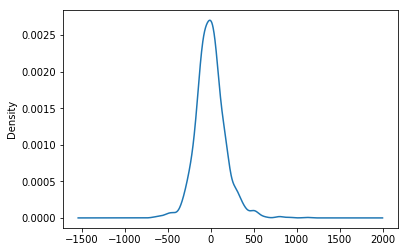

In [145]:
df_linear['combPred'] = lm.predict()
df_linear['resid'] = df_linear['nCabs'] - df_linear['combPred']
df_linear['resid'].plot(kind='kde')

### Model 2: With Intercept

In [146]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights+arPred', data = df_linear).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     4353.
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:17:26   Log-Likelihood:                -9503.5
No. Observations:                1447   AIC:                         1.901e+04
Df Residuals:                    1444   BIC:                         1.903e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -21.2038     11.626     -1.824      0.0

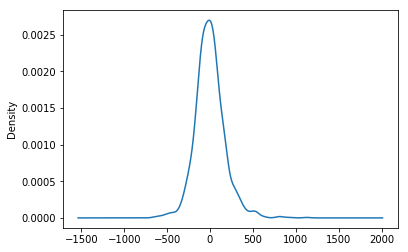

In [147]:
df_linear['combPred'] = lm.predict()
df_linear['resid'] = df_linear['nCabs'] - df_linear['combPred']
df_linear['resid'].plot(kind='kde')

### Model 3: With all Features

In [149]:
# fit a linear model between outgoing cab and incoming flight
lm = smf.ols(formula='nCabs~nFlights+arPred+Day_0+Day_1+Day_2+Day_3+Day_4+Day_5+Day_6+Time_1+\
Time_2+Time_3+Time_4+Time_5+Time_6+Time_7+Time_8', data = df_linear).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  nCabs   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     867.0
Date:                Thu, 06 Jun 2019   Prob (F-statistic):               0.00
Time:                        22:21:20   Log-Likelihood:                -9242.1
No. Observations:                1447   AIC:                         1.852e+04
Df Residuals:                    1431   BIC:                         1.860e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     86.8067     20.458      4.243      0.0

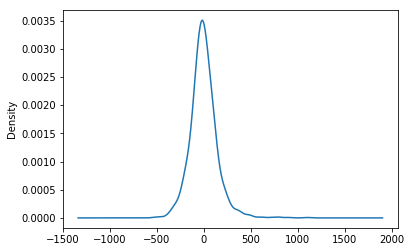

In [150]:
df_linear['combPred'] = lm.predict()
df_linear['resid'] = df_linear['nCabs'] - df_linear['combPred']
df_linear['resid'].plot(kind='kde')

## OUTLIER DETECTION

In [74]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [75]:
df_linear['Outlier'] = is_outlier(df_linear['resid'], thresh = 3.5)

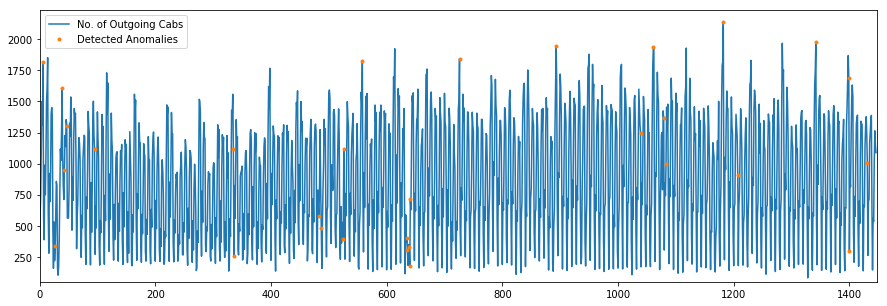

In [77]:
plt.subplots(figsize = (15,5))
plt.plot(np.arange(0, len(df_linear)), df_linear['nCabs'], label='No. of Outgoing Cabs')
plt.plot(np.arange(0, len(df_linear)), df_linear['nCabs']*df_linear['Outlier'], '.', label ='Detected Anomalies')
plt.ylim(50, max(df_linear['nCabs']+100))
plt.xlim(0, len(df_linear))
plt.legend()